# Outline
## graph-predict
### 模型搭建
### 模型评价与改进
#### 模型对比
#### 数据增强
#### 模型改进

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import time
import jieba
import random
import json
import ast
import os
from torchvision import transforms
from PIL import Image

In [3]:
df=pd.read_csv('broaden_data.csv')
df.head()

,num,name,price,sales,shop_name,shop_link,product_link,image_link,shipping_insurance,free_shipping,...,充绒量,含绒量,穿搭方式,绒子含量,货号,上市年份季节,销售渠道类型,材质成分,size_count,color_count
0,0,雅鹿正品男士加厚羽绒服中长款2023冬季新款中年冬装保暖外套,399,29,恒源祥皮衣工厂直营店,https://click.simba.taobao.com/cc_im?p=%D3%F0%...,https://click.simba.taobao.com/cc_im?p=%D3%F0%...,https://img.alicdn.com/imgextra/i4/58023241/O1...,True,True,...,200g(含)-250g(不含),90%,外穿,90%(含)-95%(不含),NaN,NaN,NaN,NaN,6,2
1,1,MOOSE KNUCKLES 3Q JKT 大毛领保暖运动羽绒服夹克男,11800,2,MOOSE KNUCKLES官方旗舰店,https://click.simba.taobao.com/cc_im?p=%D3%F0%...,https://click.simba.taobao.com/cc_im?p=%D3%F0%...,https://img.alicdn.com/imgextra/i2/219310104/O...,False,True,...,300g及以上（含）,80%,NaN,NaN,MK8681M3QK,2022年冬季,商场同款(线上线下都销售),棉74% 聚酰胺纤维(锦纶)26%,5,2
2,2,中长款连帽男士羽绒服冬季2023新款潮牌加厚90白鸭绒男生冬装外套,249,99,VUUG旗舰店,https://store.taobao.com/shop/view_shop.htm?ap...,https://detail.tmall.com/item.htm?id=741999329...,https://g-search2.alicdn.com/img/bao/uploaded/...,False,True,...,100g(含)-150g(不含),90%,外穿,90%(含)-95%(不含),V-114180W20311-1006,2023年冬季,纯电商(只在线上销售),聚酯纤维100%,6,3
3,3,羽绒服男士冬季2023新款美式潮牌立领工装白鸭绒情侣加厚保暖外套,209,93,antin soul studios旗舰店,https://store.taobao.com/shop/view_shop.htm?ap...,https://detail.tmall.com/item.htm?id=745909583...,https://g-search1.alicdn.com/img/bao/uploaded/...,False,True,...,100g(含)-150g(不含),90%,外穿,85%(含)-90%(不含),QWN-2310301803,2023年冬季,NaN,聚酯纤维100%,5,14
4,4,森马集团棉致白鸭绒羽绒服男冬季2023新款轻薄加厚短款青少年外套,275,100+,森马旗下棉致臻选店,https://store.taobao.com/shop/view_shop.htm?ap...,https://item.taobao.com/item.htm?id=7435233494...,https://g-search2.alicdn.com/img/bao/uploaded/...,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [4]:
df1=df[['num','merged_sales_category']]
df1['filename'] = df1['num'].apply(str) + '.jpg'
df1.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,num,merged_sales_category,filename
0,0,small,0.jpg
1,1,small,1.jpg
2,2,small,2.jpg
3,3,small,3.jpg
4,4,mid,4.jpg


## 读入数据

In [5]:
# 定义一个函数来转换四通道图像为三通道
def to_3_channels(img):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img
class SalesDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (pandas.DataFrame): 包含图像路径和标签的df。
            root_dir (string): 图像文件的目录。
            transform (callable, optional): 需要应用于样本的可选转换。
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label_mapping = {label: idx for idx, label in enumerate(dataframe['merged_sales_category'].unique())}


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx]['filename'])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx]['merged_sales_category']
        
        # 使用映射转换标签
        label = self.label_mapping[label]

        if self.transform:
            image = self.transform(image)

        return image, label


# 图像预处理步骤
transform = transforms.Compose([
    transforms.Lambda(to_3_channels),  # 确保图像是三通道
    transforms.Resize((460, 460)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5634, 0.5389, 0.5376], std=[0.2815, 0.2756, 0.2760]),
])

# 假设图像存放在当前目录下的 'images' 文件夹
root_dir = 'pre_pic'
dataset = SalesDataset(dataframe=df1, root_dir=root_dir, transform=transform)

# 划分数据集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 460, 460])
32


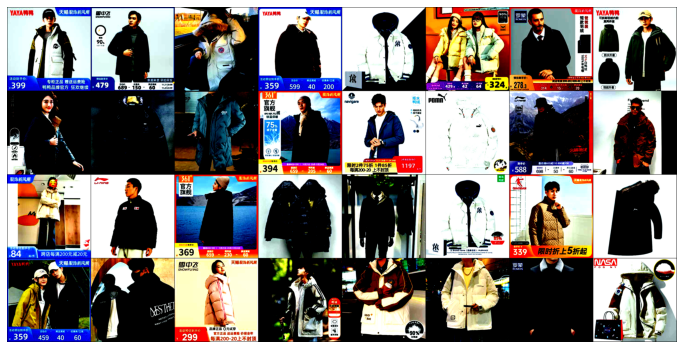

In [6]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
images, labels = next(iter(train_loader))  # 获取训练集第一个批次中的图片及相应标签
print(images[0].shape)
print(len(labels))
plt.figure(figsize=(12, 20))  # 设置画布大小
plt.axis('off')  # 隐藏坐标轴
plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

In [13]:
# 初始化累加器
mean = torch.zeros(3)
std = torch.zeros(3)
n_samples = 0

# 计算均值
for images, _ in D:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_samples += batch_samples

# 计算总均值和标准差
mean /= n_samples
std /= n_samples

print(mean,std)


tensor([0.5634, 0.5389, 0.5376]) tensor([0.2815, 0.2756, 0.2760])


## 模型搭建

In [7]:
class Train:
    def __init__(self, train_loader, test_loader):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_loader = train_loader
        self.test_loader = test_loader
        
        self.model_info = {
            'max_accuracy': 0,
            'model_complexity': None, # 初始化模型复杂度为空
            'convergence_speed': None, # 初始化收敛速度为空
            'training_speed': None, # 初始化训练速度为空
            'early_stop_epoch': None ,# 初始化早停轮数为空
            'generalization':None,
        }
        self.trainloss=[]
        self.trainacc=[]
        self.validloss=[]
        self.validacc=[]

    def train_step(self, model, criterion, optimizer, info, labels):
        """执行一个训练步骤"""
        info, labels = info.to(self.device), labels.to(self.device)
        optimizer.zero_grad()
        outputs = model(info)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        return loss.item(), outputs

    def valid_step(self, model, criterion, info, labels):
        """执行一个验证步骤"""
        info, labels = info.to(self.device), labels.to(self.device)
        outputs = model(info)
        loss = criterion(outputs, labels)
        return loss.item(), outputs

    def calculate_accuracy(self, outputs, labels):
        """计算准确率"""
        labels = labels.to(outputs.device)  # 确保labels和outputs在同一设备
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        return correct / total

    def early_stopping(self, val_loss, best_loss, trigger_times, patience):
        """检查是否需要早停"""
        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
        return best_loss, trigger_times, trigger_times >= patience

    def pic(self,trainloss, trainacc, validloss, validacc):
        """绘制训练和验证的损失和准确率图"""
        epochs = range(1, len(trainloss) + 1)

        # 创建一个新的图形
        fig, ax1 = plt.subplots()

        # 绘制损失
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color='tab:red')
        ax1.plot(epochs, trainloss, label='Train Loss', color='tab:red', marker='o')
        ax1.plot(epochs, validloss, label='Validation Loss', color='tab:red', linestyle='dashed', marker='o')
        ax1.tick_params(axis='y', labelcolor='tab:red')

        # 创建双轴
        ax2 = ax1.twinx()  
        ax2.set_ylabel('Accuracy', color='tab:blue')
        ax2.plot(epochs, trainacc, label='Train Accuracy', color='tab:blue', marker='x')
        ax2.plot(epochs, validacc, label='Validation Accuracy', color='tab:blue', linestyle='dashed', marker='x')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        # 添加图例
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left')

        plt.title('Training and Validation Loss and Accuracy')
        plt.show()

    def train(self, model, epochs_num, patience, lr=0.001):
        """训练模型"""
        model=model.to(self.device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)
        best_loss = float('inf')
        trigger_times = 0
        
        self.model_info['model_complexity'] = sum(p.numel() for p in model.parameters())  # 计算模型复杂度

        trainloss, trainacc, validloss, validacc = [], [], [], []
        
        start_time = time.time()  # 开始计时

        for epoch in range(epochs_num):
            model.train()
            train_loss = train_correct = train_total = 0
        
            for info, labels in self.train_loader:
                # 移动数据到指定的设备（GPU或CPU）
                info = info.to(self.device) 
                labels=labels.to(self.device)
                
                loss, outputs = self.train_step(model, criterion, optimizer, info, labels)
                train_loss += loss
                train_accuracy = self.calculate_accuracy(outputs, labels)
                train_correct += train_accuracy * labels.size(0)
                train_total += labels.size(0)

            train_loss /= len(self.train_loader)
            train_accuracy = 100 * train_correct / train_total

            model.eval()
            val_loss = val_correct = val_total = 0
            with torch.no_grad():
                for info, labels in self.test_loader:
                    loss, outputs = self.valid_step(model, criterion, info, labels)
                    val_loss += loss
                    val_accuracy = self.calculate_accuracy(outputs, labels)
                    val_correct += val_accuracy * labels.size(0)
                    val_total += labels.size(0)

            val_loss /= len(self.test_loader)
            val_accuracy = 100 * val_correct / val_total

            best_loss, trigger_times, stop_early = self.early_stopping(val_loss, best_loss, trigger_times, patience)
            
            scheduler.step(val_loss)

            trainloss.append(train_loss)
            trainacc.append(train_accuracy)
            validloss.append(val_loss)
            validacc.append(val_accuracy)
            
            self.trainloss.append(train_loss)
            self.trainacc.append(train_accuracy)
            self.validloss.append(val_loss)
            self.validacc.append(val_accuracy)

            print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

            if stop_early:
                print(f'Epoch {epoch+1}: Early stopping!')
                break
                
        total_time = time.time() - start_time
        self.model_info['training_speed'] = total_time / epochs_num
        
        self.model_info['max_accuracy'] = max(validacc)
        #print(epoch , patience)
        self.model_info['convergence_speed'] = epoch - patience+1  # 假定在没有提前停止的情况下为最终epoch数减去耐心值
        self.model_info['early_stop_epoch'] = epoch if stop_early else epochs_num
        self.model_info['generalization'] = max(trainacc) - max(validacc)  # 计算泛化能力指标



        self.pic(trainloss, trainacc, validloss, validacc)
        
        return model

In [8]:
def log_normalize(value, min_value, max_value):
    """ 对数变换并归一化一个值 """
    # 对数变换，避免对0取对数
    log_value = np.log(value + 1 - min_value)
    log_max = np.log(max_value + 1 - min_value)
    # 归一化
    return log_value / log_max

def min_max_normalize(value, min_value, max_value):
    """ 归一化一个值 """
    return (value - min_value) / (max_value - min_value)

In [9]:
def compare(*train_objects, model_names=[]):
    # 使用seaborn风格
    sns.set(style="whitegrid")

    # 设置雷达图的标签和角度
    labels = [
    'Accuracy (min-max)', 
    'Model Complexity (log)', 
    'Convergence Speed (min-max)', 
    'Training Speed (min-max)', 
    'Generalization (min-max)'
    ]
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # 闭合图形

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # 检查model_names长度，如果不匹配，则使用默认名称
    if len(model_names) != len(train_objects):
        model_names = [f'Model {i+1}' for i in range(len(train_objects))]


    # 定义一组鲜艳的颜色
    bright_colors = [
        '#FF5733',  # 鲜红色
        '#33FF57',  # 亮绿色
        '#3357FF',  # 明亮的蓝色
        '#F933FF',  # 鲜紫色
        '#FFC733'   # 亮橙色
    ]

    # 使用这些颜色绘制雷达图
    for i, (train_obj, model_name) in enumerate(zip(train_objects, model_names)):
        stats = train_obj.model_info
        values = [
            min_max_normalize(stats['max_accuracy'], 0, 100),
            log_normalize(stats['model_complexity'], 0, 5000000),
            min_max_normalize(stats['convergence_speed'], 0, 50),
            min_max_normalize(stats['training_speed'], 0, 1),
            min_max_normalize(stats['generalization'], 0, 100)
        ]
        values += values[:1]

        # 指定颜色
        ax.plot(angles, values, label=model_name, linewidth=2, color=bright_colors[i % len(bright_colors)])
        ax.fill(angles, values, color=bright_colors[i % len(bright_colors)], alpha=0.25)



    # 设置雷达图的属性
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], labels, color='grey', size=12)
    
    # 添加标题和图例
    plt.title('Model Comparison', size=20, color='black', y=1.1)

    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.show()

In [10]:
def modify_last_layer(model, num_classes):
    if isinstance(model, models.ResNet):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif isinstance(model, models.DenseNet):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif isinstance(model, models.AlexNet) or isinstance(model, models.VGG):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model


In [11]:
import torchvision.models as models


num_classes=3
resnet50 = models.resnet50(pretrained=True)
resnet50 = modify_last_layer(resnet50, num_classes)

# ResNet101
resnet101 = models.resnet101(pretrained=True)
resnet101 = modify_last_layer(resnet101, num_classes)

# DenseNet
densenet = models.densenet121(pretrained=True)
densenet = modify_last_layer(densenet, num_classes)

vgg16 = models.vgg16(pretrained=True)
vgg16 = modify_last_layer(vgg16, num_classes)


alexnet = models.alexnet(pretrained=True)
alexnet = modify_last_layer(alexnet, num_classes)

In [12]:
# 加载预训练的 MobileNetV2 并修改最后一层
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
num_ftrs = mobilenet_v2.classifier[1].in_features
mobilenet_v2.classifier[1] = nn.Linear(num_ftrs, num_classes)

# 加载预训练的 SqueezeNet 并修改最后一层
squeezenet = models.squeezenet1_1(pretrained=True)
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
squeezenet.num_classes = num_classes

In [28]:
epochs_num = 100
patience = 20
learning_rate = 0.001

Epoch 1: Train Loss: 0.8419, Train Accuracy: 53.29%, Validation Loss: 0.8096, Validation Accuracy: 58.13%
Epoch 2: Train Loss: 0.8018, Train Accuracy: 55.93%, Validation Loss: 0.7957, Validation Accuracy: 57.45%
Epoch 3: Train Loss: 0.8029, Train Accuracy: 57.16%, Validation Loss: 0.7925, Validation Accuracy: 57.91%
Epoch 4: Train Loss: 0.7893, Train Accuracy: 57.81%, Validation Loss: 0.8667, Validation Accuracy: 57.68%
Epoch 5: Train Loss: 0.7812, Train Accuracy: 58.89%, Validation Loss: 0.7979, Validation Accuracy: 56.54%
Epoch 6: Train Loss: 0.7793, Train Accuracy: 57.92%, Validation Loss: 0.7875, Validation Accuracy: 58.25%
Epoch 7: Train Loss: 0.7698, Train Accuracy: 59.57%, Validation Loss: 0.8045, Validation Accuracy: 56.54%
Epoch 8: Train Loss: 0.7764, Train Accuracy: 58.81%, Validation Loss: 0.8270, Validation Accuracy: 54.38%
Epoch 9: Train Loss: 0.7654, Train Accuracy: 59.72%, Validation Loss: 0.7814, Validation Accuracy: 59.95%
Epoch 10: Train Loss: 0.7614, Train Accuracy: 

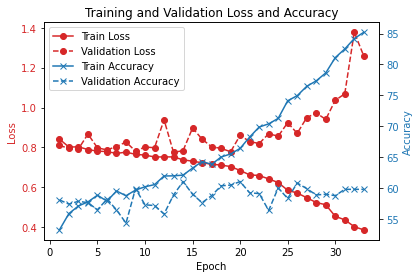

In [20]:
train1=Train(train_loader,test_loader)


# 开始训练模型
trained1 = train1.train(resnet50, epochs_num, patience, learning_rate)

In [24]:
torch.cuda.empty_cache()

In [ ]:
train2=Train(train_loader,test_loader)

# 开始训练模型
trained2 = train2.train(resnet101, epochs_num, patience, learning_rate)

train3=Train(train_loader,test_loader)

trained3 = train3.train(densenet, epochs_num, patience, learning_rate)

In [ ]:
train4=Train(train_loader,test_loader)

trained4 = train4.train(vgg16, epochs_num, patience, learning_rate)

Epoch 1: Train Loss: 1.5948, Train Accuracy: 49.45%, Validation Loss: 0.8251, Validation Accuracy: 55.18%
Epoch 2: Train Loss: 0.8324, Train Accuracy: 49.45%, Validation Loss: 0.8298, Validation Accuracy: 55.18%
Epoch 3: Train Loss: 0.8336, Train Accuracy: 50.01%, Validation Loss: 0.8164, Validation Accuracy: 55.18%
Epoch 4: Train Loss: 0.8337, Train Accuracy: 48.99%, Validation Loss: 0.8197, Validation Accuracy: 55.18%
Epoch 5: Train Loss: 0.8344, Train Accuracy: 49.59%, Validation Loss: 0.8149, Validation Accuracy: 55.18%
Epoch 6: Train Loss: 0.8349, Train Accuracy: 49.56%, Validation Loss: 0.8183, Validation Accuracy: 55.18%
Epoch 7: Train Loss: 0.8324, Train Accuracy: 50.16%, Validation Loss: 0.8138, Validation Accuracy: 55.18%
Epoch 8: Train Loss: 0.8312, Train Accuracy: 49.64%, Validation Loss: 0.8183, Validation Accuracy: 55.18%
Epoch 9: Train Loss: 0.8298, Train Accuracy: 49.64%, Validation Loss: 0.8170, Validation Accuracy: 55.18%
Epoch 10: Train Loss: 0.8312, Train Accuracy: 

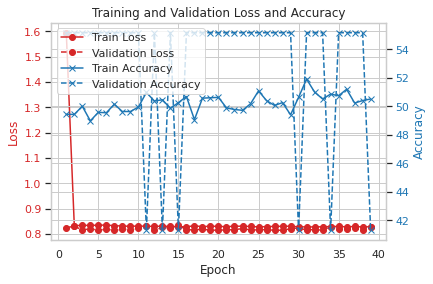

In [132]:
train4.pic(train4.trainloss, train4.trainacc, train4.validloss, train4.validacc)

Epoch 1: Train Loss: 0.9368, Train Accuracy: 50.67%, Validation Loss: 0.8147, Validation Accuracy: 51.99%
Epoch 2: Train Loss: 0.8327, Train Accuracy: 49.64%, Validation Loss: 0.8293, Validation Accuracy: 44.60%
Epoch 3: Train Loss: 0.8306, Train Accuracy: 50.75%, Validation Loss: 0.8262, Validation Accuracy: 51.99%
Epoch 4: Train Loss: 0.8311, Train Accuracy: 51.69%, Validation Loss: 0.8148, Validation Accuracy: 51.99%
Epoch 5: Train Loss: 0.8312, Train Accuracy: 51.55%, Validation Loss: 0.8156, Validation Accuracy: 51.99%
Epoch 6: Train Loss: 0.8299, Train Accuracy: 51.41%, Validation Loss: 0.8154, Validation Accuracy: 51.99%
Epoch 7: Train Loss: 0.8288, Train Accuracy: 51.44%, Validation Loss: 0.8144, Validation Accuracy: 51.99%
Epoch 8: Train Loss: 0.8287, Train Accuracy: 51.41%, Validation Loss: 0.8197, Validation Accuracy: 44.60%
Epoch 9: Train Loss: 0.8275, Train Accuracy: 51.61%, Validation Loss: 0.8213, Validation Accuracy: 51.99%
Epoch 10: Train Loss: 0.8291, Train Accuracy: 

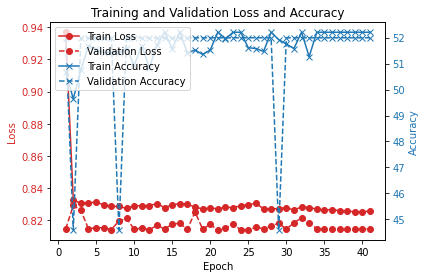

In [16]:
train5=Train(train_loader,test_loader)

trained5 = train5.train(alexnet, epochs_num, patience, learning_rate)

In [ ]:

train6=Train(train_loader,test_loader)

trained6 = train6.train(mobilenet_v2, epochs_num, patience, learning_rate)

Epoch 1: Train Loss: 0.8447, Train Accuracy: 54.11%, Validation Loss: 0.8878, Validation Accuracy: 43.00%


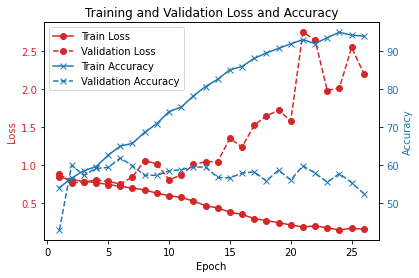

In [35]:
train6.pic(train6.trainloss, train6.trainacc, train6.validloss, train6.validacc)

In [ ]:

train7=Train(train_loader,test_loader)

trained7 = train7.train(squeezenet, epochs_num, patience, learning_rate)

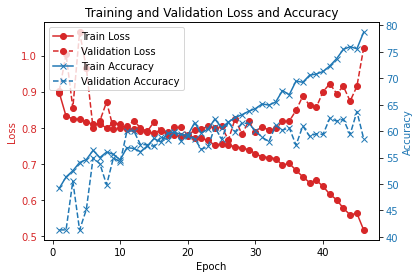

In [37]:
train7.pic(train7.trainloss, train7.trainacc, train7.validloss, train7.validacc)

63.70875995449374

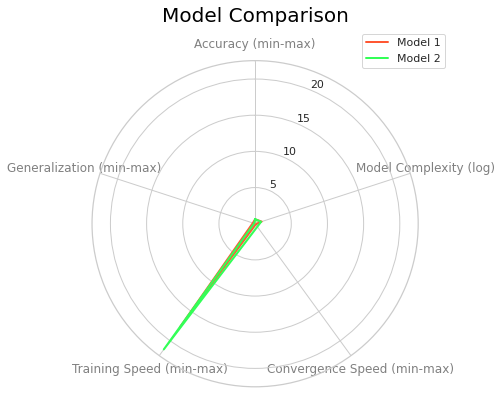

In [38]:
compare(train6,train7)

In [ ]:

import time

counter = 0
while True:
    print(f"Counter: {counter}")
    counter += 1
    time.sleep(5)  # 等待5秒


Counter: 0
Counter: 1
Counter: 2
Counter: 3
Counter: 4


## 数据增强

In [13]:
class AugmentedSalesDataset(SalesDataset):
    def __init__(self, dataframe, root_dir, transform=None, augment_transform=None, categories_to_augment=[], num_augment=[]):
        """
        初始化 AugmentedSalesDataset.
        Args:
            dataframe (pandas.DataFrame): 包含图像路径和标签的DataFrame.
            root_dir (string): 图像文件的目录.
            transform (callable, optional): 需要应用于所有样本的可选转换.
            augment_transform (callable, optional): 需要应用于增强样本的转换.
            categories_to_augment (list): 需要增强的类别列表.
            num_augment (int): 每个需要增强的类别增加的样本数.
        """
        # 调用父类的构造函数
        super().__init__(dataframe, root_dir, transform)
        self.augment_transform = augment_transform
        
        # 如果提供了需要增强的类别
        if categories_to_augment:
            augmented_data = []
            for index,category in enumerate(categories_to_augment):
                # 筛选出特定类别的数据
                category_data = dataframe[dataframe['merged_sales_category'] == category]
                
                # 如果特定类别的数据不为空
                if not category_data.empty:
                    # 复制数据，允许重复抽样
                    sampled_data = category_data.sample(n=num_augment[index], replace=True, random_state=1).reset_index(drop=True)
                    sampled_data['is_aug'] = True  # 添加标识，表示这是增强的数据
                    augmented_data.append(sampled_data)
            
            # 合并增强数据与原始数据
            if augmented_data:
                augmented_data = pd.concat(augmented_data, ignore_index=True)
                
                augmented_data['is_aug'] = augmented_data['is_aug'].fillna(False)
                self.dataframe = pd.concat([self.dataframe, augmented_data], ignore_index=True)
                
                # 更新标签映射，因为可能添加了新的数据
                self.label_mapping = {label: idx for idx, label in enumerate(self.dataframe['merged_sales_category'].unique())}

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(os.path.join(self.root_dir, row['filename']))
        label = self.label_mapping[row['merged_sales_category']]
        
        # 判断是否是增强的数据并应用相应的变换
        if row.get('is_aug', False) and self.augment_transform:
            image = self.augment_transform(image)
        else:
            image = self.transform(image)
            
        return image, label

basic_transform = transforms.Compose([
    transforms.Lambda(to_3_channels),  # 确保图像是三通道
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(460, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5634, 0.5389, 0.5376], std=[0.2815, 0.2756, 0.2760]),
])


In [14]:
# 创建增强后的数据集
augmented_dataset = AugmentedSalesDataset(
    dataframe=df1, 
    root_dir='pre_pic', 
    transform=transform,  # 应用于所有样本的基本变换
    augment_transform=basic_transform,  # 应用于增强样本的变换
    categories_to_augment=['high'],  # 增加 'high' 和 'mid' 类别
    num_augment=[850] # 每个类别增加 1000 个样本
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


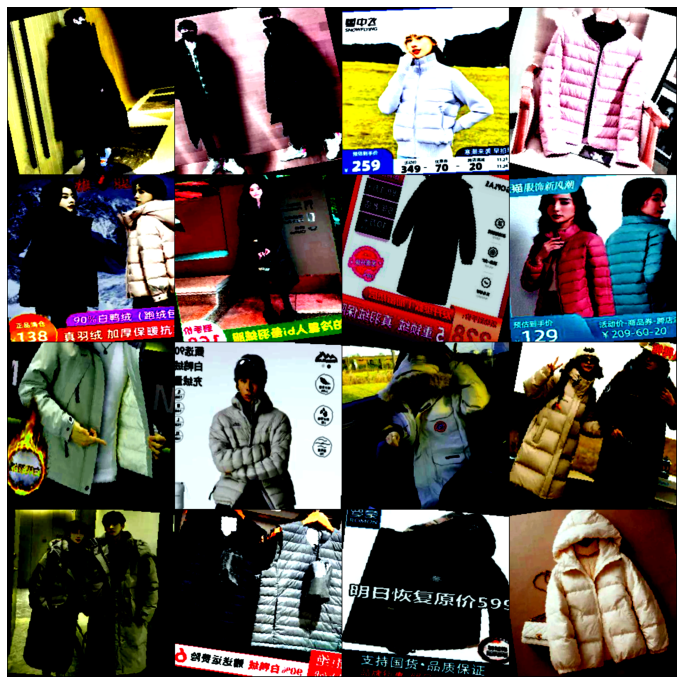

In [15]:
# 设置随机种子以确保可重复性
random.seed(42)
torch.manual_seed(42)

# 设置参数
num_images = 16  # 显示的图像数量
min_index = 4396  # 索引的最小值

# 确保索引不会超过数据集的大小
max_index = min(len(augmented_dataset), min_index + num_images)

# 随机选择16个索引
indices = random.sample(range(min_index, max_index), num_images)

# 从augmented_dataset中获取图像和标签
images = []
for idx in indices:
    image, _ = augmented_dataset[idx]  # 获取图像，忽略标签
    images.append(image)

# 创建一个网格图像
grid_image = make_grid(images, nrow=4)  # nrow参数决定每行显示多少图像

# 绘制图像
plt.figure(figsize=(12, 20))
plt.axis('off')  # 隐藏坐标轴
plt.imshow(grid_image.permute(1, 2, 0))  # make_grid函数把多张图片一起显示，permute函数调换channel维的顺序
plt.show()

In [16]:

# 划分数据集
train_size2 = int(0.8 * len(augmented_dataset))
test_size2 = len(augmented_dataset) - train_size2
train_dataset2, test_dataset2 = random_split(augmented_dataset, [train_size2, test_size2])

# 创建 DataLoader
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

### 模型改进

#### 迁移学习

In [87]:
resnet50_aug = models.resnet50(pretrained=True)
resnet50_aug  = modify_last_layer(resnet50, num_classes)

# 加载预训练的 MobileNetV2 并修改最后一层
mobilenet_v2_aug  = models.mobilenet_v2(pretrained=True)
num_ftrs_aug  = mobilenet_v2_aug.classifier[1].in_features
mobilenet_v2_aug.classifier[1] = nn.Linear(num_ftrs_aug , num_classes)

# 加载预训练的 SqueezeNet 并修改最后一层
squeezenet_aug  = models.squeezenet1_1(pretrained=True)
squeezenet_aug.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
squeezenet_aug.num_classes = num_classes

In [141]:

vgg16_aug = models.vgg16(pretrained=True)
vgg16_aug = modify_last_layer(vgg16_aug, num_classes)

In [ ]:
train8=Train(train_loader2,test_loader2)
trained8 = train8.train(resnet50_aug, epochs_num, patience, learning_rate)

In [ ]:
trained8=train8.train(trained8, 50, patience, learning_rate)

In [123]:
torch.save(trained8, 'model8.pth')

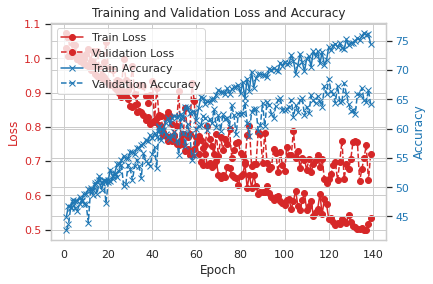

In [122]:
train8.pic(train8.trainloss, train8.trainacc, train8.validloss, train8.validacc)

In [ ]:
train9=Train(train_loader2,test_loader2)
trained9 = train9.train(mobilenet_v2_aug, epochs_num, patience, learning_rate)

In [ ]:
trained9=train9.train(trained9, 5, patience, learning_rate)

In [125]:
torch.save(trained9, 'model9.pth')

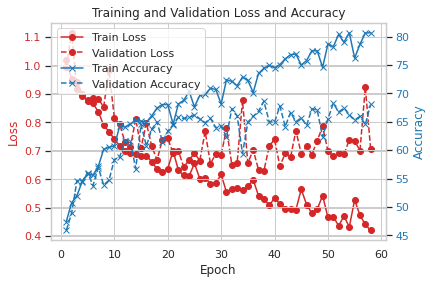

In [124]:
train9.pic(train9.trainloss, train9.trainacc, train9.validloss, train9.validacc)

In [ ]:
train10=Train(train_loader2,test_loader2)
trained10 = train10.train(squeezenet_aug, epochs_num, patience, learning_rate)

Epoch 1: Train Loss: 0.4847, Train Accuracy: 76.59%, Validation Loss: 0.7202, Validation Accuracy: 65.87%
Epoch 2: Train Loss: 0.4875, Train Accuracy: 77.02%, Validation Loss: 0.7133, Validation Accuracy: 65.78%
Epoch 3: Train Loss: 0.5191, Train Accuracy: 75.59%, Validation Loss: 0.7119, Validation Accuracy: 63.78%
Epoch 4: Train Loss: 0.5241, Train Accuracy: 74.68%, Validation Loss: 0.7154, Validation Accuracy: 67.30%
Epoch 5: Train Loss: 0.4894, Train Accuracy: 76.23%, Validation Loss: 0.7687, Validation Accuracy: 66.44%
Epoch 6: Train Loss: 0.4745, Train Accuracy: 77.76%, Validation Loss: 0.6925, Validation Accuracy: 66.73%
Epoch 7: Train Loss: 0.4766, Train Accuracy: 77.47%, Validation Loss: 0.7360, Validation Accuracy: 66.25%
Epoch 8: Train Loss: 0.4797, Train Accuracy: 77.28%, Validation Loss: 0.8351, Validation Accuracy: 64.06%
Epoch 9: Train Loss: 0.4849, Train Accuracy: 77.31%, Validation Loss: 0.7292, Validation Accuracy: 66.54%
Epoch 10: Train Loss: 0.4847, Train Accuracy: 

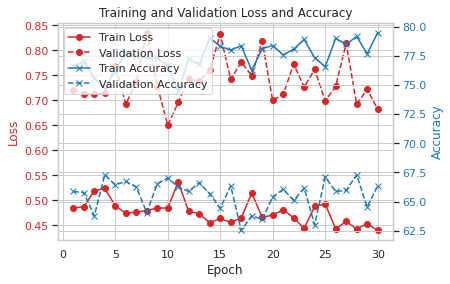

In [144]:
trained10=train10.train(trained10, 50, patience, learning_rate)

In [127]:
torch.save(trained10, 'model10.pth')

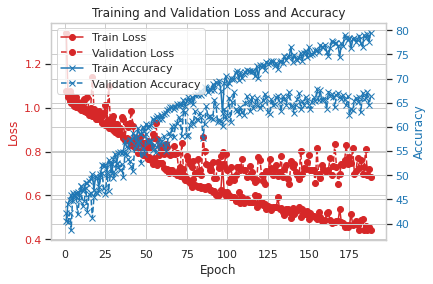

In [145]:
train10.pic(train10.trainloss, train10.trainacc, train10.validloss, train10.validacc)

67.8741658722593

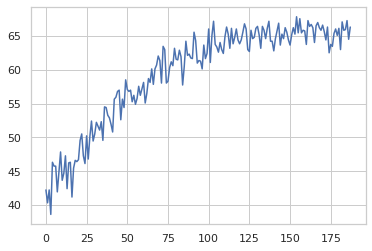

In [147]:
plt.plot(train10.validacc)
max(train10.validacc)

In [137]:
torch.cuda.empty_cache()

In [ ]:
train11=Train(train_loader2,test_loader2)
trained11 = train11.train(vgg16_aug, epochs_num, patience, learning_rate)

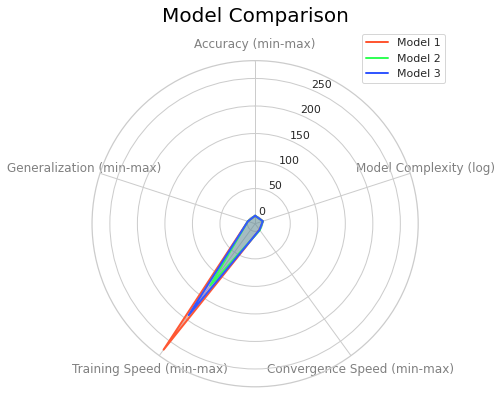

In [118]:
compare(train8,train9,train10)

### 全体增强

In [17]:
# 创建增强后的数据集
augmented_dataset2 = AugmentedSalesDataset(
    dataframe=df1, 
    root_dir='pre_pic', 
    transform=transform,  # 应用于所有样本的基本变换
    augment_transform=basic_transform,  # 应用于增强样本的变换
    categories_to_augment=['high',"mid",'small'],  # 增加 'high' 和 'mid' 类别
    num_augment=[850,500,500] # 每个类别增加 1000 个样本
)



In [18]:
# 划分数据集
train_size3 = int(0.8 * len(augmented_dataset2))
test_size3 = len(augmented_dataset2) - train_size3
train_dataset3, test_dataset3 = random_split(augmented_dataset2, [train_size3, test_size3])

# 创建 DataLoader
train_loader3 = DataLoader(train_dataset3, batch_size=32, shuffle=True)
test_loader3 = DataLoader(test_dataset3, batch_size=32, shuffle=False)

In [167]:
# 加载预训练的 SqueezeNet 并修改最后一层
squeezenet_aug2  = models.squeezenet1_1(pretrained=True)
#squeezenet_aug2.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
squeezenet_aug2.num_classes = num_classes

In [ ]:
train11=Train(train_loader3,test_loader3)
trained11 = train11.train(squeezenet_aug2, 200, 50, learning_rate)

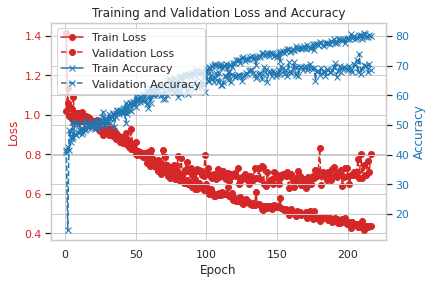

In [181]:
train11.pic(train11.trainloss, train11.trainacc, train11.validloss, train11.validacc)

In [182]:
torch.save(trained11, 'model11.pth')

In [ ]:
model_mobilenet = models.mobilenet_v2(pretrained=True)
num_classes = 3
model_mobilenet.classifier[1] = torch.nn.Linear(model_mobilenet.last_channel, num_classes)
train12=Train(train_loader3,test_loader3)
trained12 = train12.train(model_mobilenet, 200, 50, 10e-3)

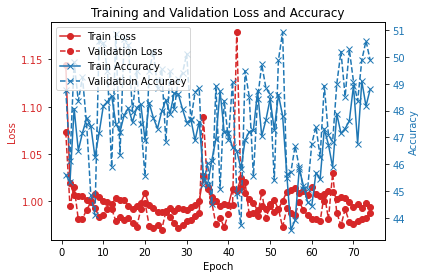

In [22]:
train12.pic(train12.trainloss, train12.trainacc, train12.validloss, train12.validacc)